## Importing packages

Importing all needed packages for the full notebook. Only needs to be ran once. 

In [101]:
import gzip as gz
import json
import pandas as pd
import spacy as sp
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


## Importing data

In [4]:
# Setting local file path
path = "release/train.jsonl.gz"

# Creating list entity to hold full set of loaded data
data = []

# Using gz to set path to zip file and iteritavly load each json line
with gz.open(path) as f:
    for ln in f:
        obj = json.loads(ln)
        data.append(obj)

In [5]:
# Extracting appropriate data and transforming to pandas dataframe
df = pd.DataFrame(data[0:100000])
df_extractive = df[df.density_bin == 'extractive']

### Sentence splitting and tokenization

In [6]:
nlp = sp.load("en_core_web_sm", disable=["tagger", "parser", "ner", "textcat"])
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [50]:
# SENTENCE SPLITTING FUNCTION
def sentence_splitting(doc):
    doc = nlp(doc['text'])
    sentences = [sent.string.strip() for sent in doc.sents]
    
    tokenized_sentences = []
    all_tokens = []
    for sentence in doc.sents:
        tokens = []
        for token in sentence:
            if token.is_stop == False and token.is_alpha == True:
                t = token.lemma_.lower()
                tokens.append(t)
                all_tokens.append(t)
        tokenized_sentences.append(tokens)  
    
    
    return sentences, tokenized_sentences, all_tokens

In [51]:
sentences, tokenized_sentences, all_tokens = sentence_splitting(df_extractive.iloc[0])

## Sentence vector representation

In [55]:
model = Word2Vec(tokenized_sentences, min_count=1,size= 300)

In [85]:
sentence_vectors = []
for sentence in tokenized_sentences:
    vec = np.zeros(300)
    for token in sentence:
        vec = vec + model.wv[token]
    vec = vec/len(vec)
    sentence_vectors.append(vec)

## Sentence clustering with Kmeans

In [87]:
k = 3
kmeans = KMeans(k, init = 'k-means++', random_state = 42)
kmeans_pred = kmeans.fit_predict(sentence_vectors)

In [91]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(sentence_vectors)

In [110]:
np.reshape(Y_sklearn, (2,32)), Y_sklearn

(array([[ 3.24481768e-05, -1.30557447e-05, -1.71269646e-05,
          3.06366146e-05,  1.00310604e-04, -3.60719937e-05,
          2.04512159e-05, -9.46763329e-06, -4.55013112e-05,
         -3.39193797e-05, -3.60554370e-05, -9.62565581e-06,
         -5.69423913e-05, -1.78733780e-05, -6.73275026e-05,
         -1.19859098e-05, -6.14429772e-05, -4.79339556e-05,
          2.71659559e-05,  7.63209008e-06, -4.24309569e-06,
          4.81253839e-05,  5.16895534e-06,  1.07134044e-05,
         -2.48470912e-05, -5.54324607e-05, -4.33249894e-06,
         -2.68569712e-05, -1.36004691e-05,  4.90802874e-07,
         -1.51935165e-04, -3.77466711e-06],
        [-4.55505590e-06, -1.95631890e-05, -2.74449107e-05,
          3.39639730e-05,  4.81683801e-05,  1.56436453e-04,
          2.31026889e-05,  5.99330558e-05,  1.21427253e-05,
         -1.69677323e-05,  6.22282902e-06, -7.84119503e-06,
         -2.06002433e-05, -1.70575011e-05,  3.26547523e-06,
          7.28854987e-05,  8.84816816e-05, -7.08960531e-

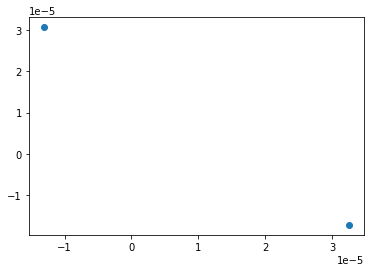

In [105]:
plt.scatter(Y_sklearn[0],Y_sklearn[1])